## Testing the Reading and Manipulation of Data

This is a testbed Jupyter notebook to read in the data we need for the COVID Data Vizualization Project.

- Possible data sources that we are considering are imported and manipulated below just to provide demonstrations of how it is done.  

- I am currently using `Pandas` (aka Python Data Analysis Library, see https://pandas.pydata.org) to read in the CSV files and manipualte them.  This has advantages and annoyances, there may be much better ways to do this, but I was giving this a try for now.

- Some of the data includes FIPS codes (a standard geographic identifier) which should ease the process of cross-matching of data.  Clay County is 27027 and Cass County is 38017.  Minnesota is 27, North Dakota is 38.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import git
import requests
from datetime import date, timedelta

In [2]:
## Define variables of interest below
data_dir = 'our_data/'    # Data directory for files we created

## US Census Data on Populations of States/Counties (FIPS Present)

This is data from the US Census Bureau estimating the population in July 2019.  Description of the file format is at https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2019/co-est2019-alldata.pdf

- **County Level Data**: https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv
- **State Level Data**: https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv



In [3]:
## Retrieve state level data (restricted to certain columns)
## When I retrieved the files, I got an error that `UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf1 in position 2: invalid continuation byte`, turns out it is encoded `latin-1`.
#census_state_csv = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"
#state_columns_of_interest = {'STATE', 'NAME', 'CENSUS2010POP', 'N_POPCHG2019', 'POPESTIMATE2019'}
#census_state_df = pd.read_csv(census_state_csv, usecols=state_columns_of_interest, encoding='latin-1')    # County totals

# Create pandas dataframes containing the selected population data for each state/county
census_county_csv = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv"
county_columns_of_interest = {'STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'NPOPCHG_2019', 'POPESTIMATE2019'}
census_county_df = pd.read_csv(census_county_csv,usecols=county_columns_of_interest, encoding='latin-1')  

# Separate state level data from county level data (by creating separate copies in memory)
county_data_df = census_county_df[census_county_df['COUNTY'] != 0].copy()
state_data_df = census_county_df[census_county_df['COUNTY'] == 0].copy()

In [4]:
# Manipulate the state-leve data

# Add FIPS column for state data then DROP county data and move FIPS to first column before exporting
state_data_df['FIPS'] = state_data_df['STATE']
state_data_df.drop(columns=['STATE','COUNTY','CTYNAME'], inplace=True)
state_data_df = state_data_df.reindex(columns=(['FIPS'] + list([col for col in state_data_df.columns if col != 'FIPS']) ))

# Compute percent change in population in 2018-19
state_data_df['PPOPCHG_2019'] = 100*(state_data_df['NPOPCHG_2019']/state_data_df['POPESTIMATE2019'])

# We may want to do a daily extrapolation of population since POPESTIMATE2019 is est. population on July 1, 2019 
# and NPOPCHG_2019 is the estimated change between July 1, 2018 and July 1, 2019.  Realistically, this is probably
# overkill since the increased deaths from Coronavirus are not taken into account in such an extrapolation.

# Save the processed data file
out_states = data_dir + "population_data_states.csv"
state_data_df.to_csv(out_states)

In [5]:
state_data_df[(state_data_df['STNAME'] == 'Minnesota') | (state_data_df['STNAME'] == 'North Dakota')]

,FIPS,STNAME,POPESTIMATE2019,NPOPCHG_2019,PPOPCHG_2019
1337,27,Minnesota,5639632,33383,0.591936
2024,38,North Dakota,762062,3982,0.522530


In [6]:
# In county data create FIPS column, remove redundant columns, and then move FIPS columns to first column
county_data_df['FIPS'] = county_data_df['STATE']*1000 + county_data_df['COUNTY']
county_data_df.drop(columns=['STATE','COUNTY'], inplace=True)
county_data_df = county_data_df.reindex(columns=(['FIPS'] + list([col for col in county_data_df.columns if col != 'FIPS']) ))

# Compute percent change in population in 2018-19
county_data_df['PPOPCHG_2019'] = 100*(county_data_df['NPOPCHG_2019']/county_data_df['POPESTIMATE2019'])

# We may want to do a daily extrapolation of population since POPESTIMATE2019 is est. population on July 1, 2019 
# and NPOPCHG_2019 is the estimated change between July 1, 2018 and July 1, 2019.  Realistically, this is probably
# overkill since the increased deaths from Coronavirus are not taken into account in such an extrapolation.

# Save the processed data file
out_counties = data_dir + "population_data_counties.csv"
county_data_df.to_csv(out_counties)


In [7]:
county_data_df[(county_data_df['FIPS'] == 27027) | (county_data_df['FIPS'] == 38017)]

,FIPS,STNAME,CTYNAME,POPESTIMATE2019,NPOPCHG_2019,PPOPCHG_2019
1351,27027,Minnesota,Clay County,64222,205,0.319205
2033,38017,North Dakota,Cass County,181923,1629,0.895434


##  Novel Coronavirus (COVID-19) Cases Data (FIPS Present)
    - https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases

This dataset is part of COVID-19 Pandemic Novel Corona Virus (COVID-19) epidemiological data since 22 January 2020. The data is compiled by the Johns Hopkins University Center for Systems Science and Engineering (JHU CCSE) from various sources including the World Health Organization (WHO), DXY.cn, BNO News, National Health Commission of the People’s Republic of China (NHC), China CDC (CCDC), Hong Kong Department of Health, Macau Government, Taiwan CDC, US CDC, Government of Canada, Australia Government Department of Health, European Centre for Disease Prevention and Control (ECDC), Ministry of Health Singapore (MOH), and others. JHU CCSE maintains the data on the 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository on Github (https://github.com/CSSEGISandData/COVID-19).

### Notes about this process: 
- By processing the population data first, I can get a list of legitimate 'FIPS' values to use, so that I can perform 'left' joins to a list of FIPS addresses instead of costly 'outer' joins.
- It turns out there are DUPLICATE FIPS entries for some of the John Hopkins data.  So I went through those and picked out the ones with the higher values for confirmed/deaths/recovered assuming they were entered later.
- Once that was done, I constructed a SINGLE Pandas dataframe holding all the time-series data and wrote it to a CSV file.  Accessing this one file will be a lot faster than looping through all the datafiles each time we load up the data.

In [13]:
# To make sure we have current data, I went to the directory containing this Jupyter script and 
# issued a "git clone https://github.com/CSSEGISandData/COVID-19.git" to
# pull the complete dataset from GitHub.  That created a COVID-19 directory, 
# which I renamed "JH_Data". Now it should be a short "git pull" command to keep the data up to date.
JHdata_dir = "JH_Data/"

# Daily tabulation of all confirmed/deaths/recovered data is in the following directories
daily_dir = JHdata_dir+"csse_covid_19_data/csse_covid_19_daily_reports/" # For each admin unit (in the US, that's county) for each day.
daily_us_dir = JHdata_dir+"csse_covid_19_data/csse_covid_19_daily_reports_us/" # For each state (somewhat redundant, but avoids recomputation I suppose)

g = git.cmd.Git(JHdata_dir)
status = g.pull()  # We should check status to see everything is good eventually, for now, I am using this to hide the status message from GitPython module

# Build a dataframe containing legitimate FIPS values
fips_df = county_data_df.copy()
fips_df.drop(columns=['STNAME', 'CTYNAME', 'POPESTIMATE2019', 'NPOPCHG_2019', 'PPOPCHG_2019'], inplace=True)

In [9]:
# Create CSV list generator that returns names in date order
def isodate2num(s):
    # Takes input filename of CSV file and returns it sorted by date implies assuming
    # filenames with MM-DD-YYYY.csv format, returning YYYY+MM+DD for sorting purposes.
    M = int(s[0:2])
    D = int(s[3:5])
    Y = int(s[6:10])
    return (f"{Y:04d}-{M:02d}-{D:02d}")

def date2num(s):
    # Takes input filename of CSV file and returns it sorted by date implies assuming
    # filenames with MM-DD-YYYY.csv format, returning YYYY+MM+DD for sorting purposes.
    M = int(s[0:2])
    D = int(s[3:5])
    Y = int(s[6:10])
    return (f"{Y:04d}{M:02d}{D:02d}")

def csvfiles(path):
    contents = os.listdir(path);
    csvs = [ file for file in contents if file.endswith(".csv") ]
    
    for file in sorted(csvs, key=date2num):
        yield file

def reduce_dataframe(raw_df, fips_df):
    # Reduce the raw dataframe of all COVID data to just the relevant entries for the US
    # Match to the list of known FIPS values from Census data
    
    # Perform a left join to the FIPS list
    reduced_df = fips_df.join(raw_df.set_index('FIPS'), on='FIPS', how='left').copy()

    # Here's the fund part, turns out the John Hopkins data has duplicate lines for a few FIPS
    # entries, so what I did was assume the HIGHER values of COVID confirmed, deaths, and recovered
    # were the accurate ones and just kept those.  This meant checking all the duplicates and then
    # purging them, re-writing the best values into the row of data.

    update_confirmed = {}
    update_deaths = {}
    update_recovered = {}
    # Identify duplicate FIPS entries (assumed mangled data)
    duplicates = reduced_df[reduced_df.duplicated(['FIPS'], keep='first')]
    # Loop through all data for each duplicate FIPS entry
    for index, row in duplicates.iterrows():
        max_confirmed = 0
        max_deaths = 0
        max_recovered = 0
        checkFIPS = row['FIPS']
        # Track the maximum value of confirmed/deaths/recovered for each FIPS
        for dup_ind, dup_row in reduced_df[reduced_df['FIPS'] == row['FIPS']].iterrows():
            if max_confirmed<dup_row['Confirmed']:
                max_confirmed = dup_row['Confirmed']
            if max_deaths<dup_row['Deaths']:
                max_deaths = dup_row['Deaths']
            if max_recovered<dup_row['Recovered']:
                max_recovered = dup_row['Recovered']
        update_confirmed.update( {checkFIPS : max_confirmed} )
        update_deaths.update( {checkFIPS : max_deaths} )
        update_recovered.update( {checkFIPS : max_recovered} )

    # Drop duplicates from pandas dataframe
    reduced_df.drop_duplicates(subset='FIPS', keep='first', inplace=True)

    # Fix values in duplicate lines
    for key in update_confirmed:
        reduced_df.loc[(reduced_df['FIPS'] == key), ['Confirmed', 'Deaths', 'Recovered']] = [update_confirmed[key], update_deaths[key], update_recovered[key]]
        
    # Return the fixed dataframe
    return reduced_df

# Scan through the more complete daily files and construct a single datafile for our use (restricting to US data)
# Turns out the format of these files changes with the date.  The files before March 22, 2020 were in several different
# forms and the placenames were NOT consistent.  Ignoring that early data for this.

sorted_csvs = []
dates_list = []
for file in csvfiles(daily_dir):
    # County level date only starts on March 22, before then it is a mis-mosh of place names in the Province_State field
    # So only keep that data
    this_isodate = isodate2num(file)
    this_date = date2num(file)
    if (int(this_date) >= 20200322):
        # Append to list of accessed csv files
        sorted_csvs.append(daily_dir+file)

        # Grab the data from the CSV file
        raw_df = pd.read_csv(sorted_csvs[-1])

        # Rename columns in early forms to late forms of column names for consistency
        raw_df.rename(columns={ 'Province/State': 'Province_State', 
                               'Country/Region':'Country_Region', 
                               'Last Update':'Last_Update' }, inplace = True)
        
        # Match to the list of known FIPS values from Census data, also removing duplicate rows
        reduced_df = reduce_dataframe(raw_df, fips_df)
        
        # Provide progress report
        idx = len(sorted_csvs)
        # print(f'Processing Date #{idx}: {this_isodate}')
        
        if (idx == 1):
            # Create combined dataframe sorted by FIPS
            combined_cols = ['FIPS', 'Admin2', 'Province_State', 'Lat', 'Long_']
            combined_df = reduced_df[combined_cols].copy()
            confirmed_df = fips_df.copy()
            deaths_df = fips_df.copy()
            recovered_df = fips_df.copy()
            
        ## Create dataframes for temporarily storing time series date
        # Append date to list of dates
        dates_list.append(this_isodate)
            
        # Store Confirmed by merging reduced list and renaming column
        confirmed_df = pd.merge(confirmed_df,reduced_df[['FIPS','Confirmed']],on='FIPS', how='left', copy=True)
        confirmed_col = "C"+f"{idx:03d}"
        confirmed_df.rename(columns={'Confirmed': confirmed_col}, errors="raise", inplace=True)
        
        # Store Deaths by merging reduced list and renaming column
        deaths_df = pd.merge(deaths_df,reduced_df[['FIPS','Deaths']],on='FIPS', how='left', copy=True)
        deaths_col = "D"+f"{idx:03d}"
        deaths_df.rename(columns={'Deaths': deaths_col}, errors="raise", inplace=True)
        
        # Store Recovered by merging reduced list and renaming column
        recovered_df = pd.merge(recovered_df,reduced_df[['FIPS','Recovered']],on='FIPS', how='left', copy=True)
        recovered_col = "R"+f"{idx:03d}"
        recovered_df.rename(columns={'Recovered': recovered_col}, errors="raise", inplace=True)
            
# Final cleanup (convert to integers and remove NaN)
confirmed_df = confirmed_df.replace(np.nan,0).astype('int')
deaths_df= deaths_df.replace(np.nan,0).astype('int')
recovered_df= recovered_df.replace(np.nan,0).astype('int')

# Add lists of dates to the combined dataframe as a single 'Dates' column
combined_df['Dates'] = [dates_list]*len(combined_df)
# Add time-series list of confirmed to the combined dataframe as a single 'Confirmed' column
combined_df['Confirmed'] = confirmed_df[ confirmed_df.columns[confirmed_df.columns!='FIPS'] ].values.tolist()
# Add time-series list of deaths to the combined dataframe as a single 'Deaths' column
combined_df['Deaths'] = confirmed_df[ confirmed_df.columns[confirmed_df.columns!='FIPS'] ].values.tolist()
# Add time-series list of recovered to the combined dataframe as a single 'Recovered' column
combined_df['Recovered'] = confirmed_df[ confirmed_df.columns[confirmed_df.columns!='FIPS'] ].values.tolist()

# Save the processed time-series data into single file
combined_datafile = data_dir + "time_series_CDR.csv"
combined_df.to_csv(combined_datafile)

In [10]:
# Show demonstrations of plotting this data here (NEED TO ADD THIS)

In [17]:
# Grab complete list of all csvs
world_csvs = list(csvfiles(daily_dir))
us_csvs = list(csvfiles(daily_dir))

# Build daily data filenames
daily_world_csv = daily_dir+world_csvs[-1]
daily_us_csv = daily_us_dir+us_csvs[-1]

# Create pandas dataframes containing the daily data from the CSV files (contains number of confirmed/deaths/recovered on that date)
daily_world_df = pd.read_csv(daily_world_csv)   # County/Admin totals
daily_us_df = pd.read_csv(daily_us_csv)         # State totals

In [18]:
daily_world_df[ (daily_world_df['FIPS'] == 1001) | (daily_world_df['FIPS'] == 38017) ]

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
106,1001.0,Autauga,Alabama,US,2020-05-28 02:32:31,32.539527,-86.644082,192,3,0,189,"Autauga, Alabama, US"
399,38017.0,Cass,North Dakota,US,2020-05-28 02:32:31,46.932017,-97.244472,1596,37,0,1559,"Cass, North Dakota, US"


In [19]:
daily_us_df[ (daily_us_df['FIPS'] == 27) | (daily_us_df['FIPS'] == 38) ]

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
27,Minnesota,US,2020-05-28 02:32:37,45.6945,-93.9002,22464,942,16314.0,5208.0,27,398.323862,216532.0,2796.0,4.193376,84000027,USA,3839.470377,12.446581
38,North Dakota,US,2020-05-28 02:32:37,47.5289,-99.7840,2439,56,1762.0,621.0,38,320.052699,67340.0,161.0,2.296023,84000038,USA,8836.551357,6.601066


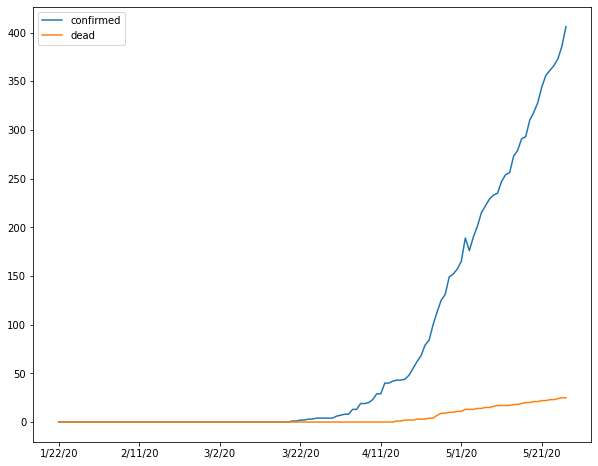

In [20]:
# Load the time series datafiles to experiment with them.

# Create pandas dataframes containing time-series data (We could reconstruct this by looping through all the daily data, since this is missing number of recovered)
ts_us_dead_csv = JHdata_dir+"csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
ts_us_confirmed_csv = JHdata_dir+"csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
ts_us_dead_df = pd.read_csv(ts_us_dead_csv)            # Deaths in time series
ts_us_confirmed_df = pd.read_csv(ts_us_confirmed_csv)  # Confirmed in time series

# We could transpose the dataframe to allow easier extraction of time series data on a per county level
tmp_df = ts_us_confirmed_df[ (ts_us_confirmed_df['Province_State'] == 'Minnesota') & (ts_us_confirmed_df['Admin2'] == 'Clay') ].T
tmp_df.rename(columns={ tmp_df.columns[0]: "confirmed" }, inplace = True)
confirmed_clay = tmp_df[tmp_df.index.str.match('[0-9]*/[0-9]*/[0-9]*')]  # Use pattern matching to find real dates and include

tmp_df = ts_us_dead_df[ (ts_us_confirmed_df['Province_State'] == 'Minnesota') & (ts_us_confirmed_df['Admin2'] == 'Clay') ].T
tmp_df.rename(columns={ tmp_df.columns[0]: "dead" }, inplace = True)
dead_clay = tmp_df[tmp_df.index.str.match('[0-9]*/[0-9]*/[0-9]*')] # Use pattern matching to find real dates and include

# Merge the confirmed ill and dead into one dataframe (would like recovered too, but that's not in
# these times series files)
merged_clay = confirmed_clay.merge(dead_clay, left_index=True, right_index=True)
merged_clay.plot(figsize=(10,8))

In [21]:
confirmed_clay

,confirmed
1/22/20,0
1/23/20,0
1/24/20,0
1/25/20,0
1/26/20,0
...,...
5/23/20,361
5/24/20,366
5/25/20,373
5/26/20,386


## Google Mobility Data (NO FIPS Present)

This data is described at https://www.google.com/covid19/mobility/ and can be downloaded in a single monolithic CSV file at https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv

> The data shows how visitors to (or time spent in) categorized places change compared to our baseline days. A baseline day represents a normal value for that day of the week. The baseline day is the median value from the 5‑week period Jan 3 – Feb 6, 2020.

> For each region-category, the baseline isn’t a single value—it’s 7 individual values. The same number of visitors on 2 different days of the week, result in different percentage changes. So, we recommend the following:
1. Don’t infer that larger changes mean more visitors or smaller changes mean less visitors.
2. Avoid comparing day-to-day changes. Especially weekends with weekdays. (https://support.google.com/covid19-mobility/answer/9824897?hl=en&ref_topic=9822927)

> Note, *Parks* typically means official national parks and not the general outdoors found in rural areas.

In [22]:
# Google Mobility Data URL
goog_mobility_csv_url = "https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv"
goog_mobility_df=pd.read_csv(goog_mobility_csv_url, low_memory=False)

In [23]:
goog_mobility_clay = goog_mobility_df[ (goog_mobility_df['sub_region_1'] == 'Minnesota') & (goog_mobility_df['sub_region_2'] == 'Clay County')]

# Notice for Clay county we have NaN reported for Parks (see note above) and Transit Stations
goog_mobility_clay

,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
283062,US,United States,Minnesota,Clay County,2020-02-15,9.0,5.0,NaN,NaN,-1.0,NaN
283063,US,United States,Minnesota,Clay County,2020-02-16,8.0,8.0,NaN,NaN,0.0,NaN
283064,US,United States,Minnesota,Clay County,2020-02-17,1.0,5.0,NaN,NaN,-21.0,5.0
283065,US,United States,Minnesota,Clay County,2020-02-18,-1.0,0.0,NaN,NaN,-4.0,3.0
283066,US,United States,Minnesota,Clay County,2020-02-19,0.0,2.0,NaN,NaN,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
283154,US,United States,Minnesota,Clay County,2020-05-17,4.0,8.0,NaN,NaN,-25.0,NaN
283155,US,United States,Minnesota,Clay County,2020-05-18,-6.0,6.0,NaN,NaN,-37.0,12.0
283156,US,United States,Minnesota,Clay County,2020-05-19,-8.0,8.0,NaN,NaN,-36.0,13.0
283157,US,United States,Minnesota,Clay County,2020-05-20,-11.0,11.0,NaN,NaN,-37.0,13.0


## Apple Mobility Data (NO FIPS Present)

This data is described at https://www.apple.com/covid19/mobility and can be downloaded in a single monolithic CSV file at https://covid19-static.cdn-apple.com/covid19-mobility-data/2008HotfixDev42/v3/en-us/applemobilitytrends-2020-05-24.csv (That URL is hidden in the mobility page link and appears to be updated regularly.  We may need to scrape the page to identify the link).

Apple tracks three kinds of Apple Maps routing requests: Driving, Walking, Transit.  In some areas not all of these types of data are available, for example, in Clay County, only Driving route request data is available.  In fact, it looks like only driving data is available at the county level regardless of the county (at least in Minnesota). Cities can contain additional formation, although only very large cities appear to be in Apple's data files.


In [24]:
# Scraping the original Apple page was proving tricky as it had a bunch of javascript used to generate the URL, so I poked around and found a reference 
# at https://www.r-bloggers.com/get-apples-mobility-data/ to a JSON file at a stable URL that can be used to construct the appropriate URL for the current
# datafile.

aapl_mobility_json = "https://covid19-static.cdn-apple.com/covid19-mobility-data/current/v3/index.json"
aapl_server = "https://covid19-static.cdn-apple.com/"
result = requests.get(aapl_mobility_json)
# Proceed if we successfully pulled the page (HTTP status code 200)
if (result.status_code == 200):
    # Apple Mobility Data URL
    jsondata = result.json()
    aapl_mobility_csv_url = aapl_server+jsondata['basePath']+jsondata['regions']['en-us']['csvPath']
    aapl_mobility_df=pd.read_csv(aapl_mobility_csv_url, low_memory=False)

In [25]:
# Just showing how I can get clay county data specifically
aapl_mobility_minneapolis = aapl_mobility_df[(aapl_mobility_df['region'] == 'Minneapolis') & (aapl_mobility_df['sub-region'] == 'Minnesota')]
aapl_mobility_clay = aapl_mobility_df[(aapl_mobility_df['region'] == 'Clay County') & (aapl_mobility_df['sub-region'] == 'Minnesota')]

In [26]:
# Notice only driving information is available here
aapl_mobility_clay

,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,...,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27
1909,county,Clay County,driving,NaN,Minnesota,United States,100.0,92.08,85.04,105.88,...,124.88,122.92,135.87,136.6,167.14,140.23,104.41,118.58,133.72,132.84


In [27]:
# Notice additional information is available for larger cities
aapl_mobility_cities = aapl_mobility_df[(aapl_mobility_df['geo_type'] == 'city') & (aapl_mobility_df['country'] == 'United States')]
aapl_mobility_cities

,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,...,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27
158,city,Akron,driving,NaN,Ohio,United States,100.0,103.06,107.50,106.14,...,108.57,119.76,123.50,129.05,135.56,130.72,104.99,96.83,131.00,132.81
159,city,Akron,transit,NaN,Ohio,United States,100.0,106.69,103.75,100.22,...,45.00,43.75,47.50,46.99,51.10,54.41,35.74,36.99,63.09,60.96
160,city,Akron,walking,NaN,Ohio,United States,100.0,97.23,79.05,74.77,...,86.90,94.93,94.67,100.19,108.84,106.54,84.12,72.99,104.32,109.56
161,city,Albany,driving,NaN,New York,United States,100.0,102.35,107.35,105.54,...,83.97,92.49,96.26,101.83,114.11,95.16,80.05,79.79,98.02,102.63
162,city,Albany,transit,NaN,New York,United States,100.0,100.14,105.95,107.76,...,56.06,56.62,55.04,54.34,55.46,54.67,45.84,52.07,55.69,59.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,city,Washington DC,walking,DC,NaN,United States,100.0,99.07,109.61,104.16,...,56.13,57.97,58.64,59.88,64.81,80.41,61.40,65.83,65.43,65.69
927,city,Wichita,driving,NaN,Kansas,United States,100.0,104.78,105.49,105.77,...,131.00,137.68,137.95,134.99,158.55,144.12,106.15,97.54,135.84,142.44
928,city,Wichita,walking,NaN,Kansas,United States,100.0,115.79,118.87,114.70,...,163.49,183.25,180.01,160.17,193.79,175.38,143.38,114.51,159.48,184.91
931,city,Worcester,driving,NaN,Massachusetts,United States,100.0,106.80,108.53,109.14,...,79.84,87.67,92.81,98.16,110.34,90.87,81.51,76.73,98.96,101.17


## IMHE Data on Local Resources

There is IMHE data on local resources at http://www.healthdata.org/covid/data-downloads although I am not sure that data is available with county level resolution as I haven't fully investigated it yet.

## NY Times Data on Probable Deaths/Cases (FIPS Present)

The NY Times has assembled data on COVID in a GitHub repository at https://github.com/nytimes/covid-19-data.  I have not examined that data yet, but it may well be interesting.

Note their statement requiring credit:

> In light of the current public health emergency, The New York Times Company is
providing this database under the following free-of-cost, perpetual,
non-exclusive license. Anyone may copy, distribute, and display the database, or
any part thereof, and make derivative works based on it, provided  (a) any such
use is for non-commercial purposes only and (b) credit is given to The New York
Times in any public display of the database, in any publication derived in part
or in full from the database, and in any other public use of the data contained
in or derived from the database.

Data is available at county, state, and national levels for live numbers (current cases/deaths as well as probable cases/deaths, updated daily).  That said, at least locally I don't think Probable cases are really making a difference.


In [28]:
# Update the NYT Datafiles
NYTdata_dir = "NYT_Data/"
g = git.cmd.Git(NYTdata_dir)
status = g.pull()  # We should check status to see everything is good eventually, for now, I am using this to hide the status message from GitPython module

In [29]:
# Grab the live data files
live_county_csv = NYTdata_dir+"live/us-counties.csv"
live_state_csv = NYTdata_dir+"live/us-states.csv"
live_us_csv = NYTdata_dir+"live/us.csv"

# Create pandas dataframes containing the daily data from the CSV files (contains number of confirmed/deaths/recovered on that date)
live_county_df = pd.read_csv(live_county_csv)   # County totals
live_state_df = pd.read_csv(live_state_csv)    # State totals
live_us_df = pd.read_csv(live_us_csv)       # National totals


In [30]:
live_county_df[ ((live_county_df['state'] == 'Minnesota') & (live_county_df['county'] == 'Clay')) | ((live_county_df['state'] == 'North Dakota') & (live_county_df['county'] == 'Cass')) ]

,date,county,state,fips,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths
1285,2020-05-28,Clay,Minnesota,27027.0,416,25.0,416.0,25.0,NaN,NaN
1888,2020-05-28,Cass,North Dakota,38017.0,1632,46.0,1632.0,46.0,NaN,NaN


In [31]:
live_state_df[ (live_state_df['state'] == 'Minnesota')]

,date,state,fips,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths
24,2020-05-28,Minnesota,27,22957,977,22947.0,967.0,10.0,10.0


In [32]:
live_us_df

,date,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths
0,2020-05-28,1721244,101217,NaN,NaN,NaN,NaN
